# Q

* Categorical var: Should I try OneHotEncoder() instead of dummies, does it change performance?

In [229]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from scipy import stats

import hazelbean as hb
L = hb.get_logger()

import seaborn as sns
import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt

In [230]:
import xgboost as xgb

# Load dataset

In [231]:
L.info('Loading data')
crop_types_df = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/aggregate_crops_by_type/aggregated_crop_data.csv')
L.info('Data loaded (1/2)')
df_land = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_regression_data.csv')
L.info('All data loaded')

df = df_land.merge(crop_types_df,how='outer',on='pixel_id')
L.info('Data merged')

df = df.drop(labels=['c3_annual_calories_per_ha', 'c3_perennial_calories_per_ha',
       'c4_annual_calories_per_ha', 'c4_perennial_calories_per_ha',
       'nitrogen_fixer_calories_per_ha'], axis=1)

Loading data
Data loaded (1/2)
All data loaded
Data merged


### Add climate zones

In [169]:
climate_zones_map = {1:'Af',2:'Am',3:'Aw',
                     5:'BWk',4:'BWh',7:'BSk',6:'BSh',
                     14:'Cfa',15:'Cfb',16:'Cfc',8:'Csa',
                     9:'Csb',10:'Csc',11:'Cwa',12:'Cwb',13:'Cwc',
                     25:'Dfa',26:'Dfb',27:'Dfc',28:'Dfd',17:'Dsa',18:'Dsb',19:'Dsc',
                     20:'Dsd',21:'Dwa',22:'Dwb',23:'Dwc',24:'Dwd',
                     30:'EF',29:'ET'}
baseline_df['climate_zone'] = baseline_df['climate_zones'].map(climate_zones_map)
baseline_df = baseline_df.drop(['Unnamed: 0','climate_zones','c3_annual_calories', 'c3_perennial_calories',
       'c4_annual_calories', 'c4_perennial_calories',
       'nitrogen_fixer_calories'], axis=1)

Loading data
Data loaded


# 2 Save validation set

In [ ]:
x = baseline_df.drop(['calories_per_cell'], axis=1)
y = baseline_df['calories_per_cell']

X, X_validation, Y, y_validation = train_test_split(x, y)

#### OR: Select a subset for faster computation (means the rest is a validation set!)

In [197]:
subset = baseline_df.sample(frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df = subset


In [205]:
df.head()

,calories_per_cell,precip,temperature,gdp_2000,minutes_to_market,workability,toxicity,rooting_conditions,protected_areas,oxygen_availability,nutrient_retention,nutrient_availability,excess_salts,gdp_gecon,slope,altitude,climate_zone
711407,0.000000e+00,578.0,0.0,33372.029454,2763.0,0.0,0.0,0.00,1.0,0.00,0.00,0.00,0.0,30797.5370,88.499820,103.0,NaN
1390993,0.000000e+00,8.0,230.0,6901.625270,480.0,0.0,0.0,0.00,1.0,0.00,0.00,0.00,0.0,0.0000,87.556160,496.0,NaN
1128517,0.000000e+00,1897.0,101.0,33963.977849,130.0,0.5,1.0,0.25,1.0,1.00,1.00,1.00,1.0,25041.4410,89.946650,294.0,NaN
1954349,5.244573e+08,855.0,213.0,582.624548,1581.0,1.0,1.0,1.00,1.0,1.00,0.75,0.75,1.0,813.0152,89.507300,1150.0,NaN
1688115,5.104816e+08,3848.0,273.0,3036.774027,635.0,1.0,1.0,1.00,1.0,0.75,1.00,1.00,1.0,5725.9670,89.474045,22.0,NaN


In [204]:
dfLog.head()

,calories_per_cell,precip,temperature,gdp_2000,minutes_to_market,workability,toxicity,rooting_conditions,protected_areas,oxygen_availability,nutrient_retention,nutrient_availability,excess_salts,gdp_gecon,slope,altitude,climate_zone,has_ag
711407,0.000000,578.0,0.0,33372.029454,2763.0,0.0,0.0,0.00,1.0,0.00,0.00,0.00,0.0,30797.5370,88.499820,103.0,NaN,0
1390993,0.000000,8.0,230.0,6901.625270,480.0,0.0,0.0,0.00,1.0,0.00,0.00,0.00,0.0,0.0000,87.556160,496.0,NaN,0
1128517,0.000000,1897.0,101.0,33963.977849,130.0,0.5,1.0,0.25,1.0,1.00,1.00,1.00,1.0,25041.4410,89.946650,294.0,NaN,0
1954349,20.077875,855.0,213.0,582.624548,1581.0,1.0,1.0,1.00,1.0,1.00,0.75,0.75,1.0,813.0152,89.507300,1150.0,NaN,1
1688115,20.050865,3848.0,273.0,3036.774027,635.0,1.0,1.0,1.00,1.0,0.75,1.00,1.00,1.0,5725.9670,89.474045,22.0,NaN,1



# 3 Data transformation 

### (a) Log

Problem: distribution super highly skewed left, stats test makes assumptions of normality.. :/


But first create a binary (has_ag) column for pixels where calories = 0 (because log doesn't deal with zeros)

In [203]:
dfLog = pd.DataFrame.copy(df)


dfLog['has_ag'] = pd.Series(len(dfLog['calories_per_cell']), index=dfLog.index)
dfLog['has_ag'] = 0 
dfLog.loc[dfLog['calories_per_cell']>0,'has_ag'] = 1

dfLog.loc[dfLog['has_ag']==1,'calories_per_cell'] = np.log(dfLog['calories_per_cell'])
 
## Why is the code above changing not only dfLog but also df itself ?! WTF??!
## Till I fugure this out - re-run subset box before each data transfo!


/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


### (b) Binning

In [207]:
dfBin = pd.DataFrame.copy(df)

#Make bin 0 for no ag cells
dfBin['has_ag'] = pd.Series(len(dfBin['calories_per_cell']), index=dfBin.index)
dfBin['has_ag'] = 0 
dfBin.loc[dfBin['calories_per_cell']>0,'has_ag'] = 1

# Make bins 1-5 for ag cells
dfBin[dfBin['has_ag']==1,'calories_per_cell'] = pd.cut(dfBin[dfBin['has_ag']==1,'calories_per_cell'],bins=5,labels=[1,2,3,4,5])

## Why ?!


TypeError: 'Series' objects are mutable, thus they cannot be hashed

### (c) Log + binning

In [93]:
dfLogBin = dfLog

dfLogBin['calories_per_cell'] = pd.cut(dfLogBin['calories_per_cell'], 5,labels=[1,2,3,4,5])

## Same Why is the code above changing not only dfLogBin but also dfLog itself ?! WTF??!
## Till I fugure this out - re-run subset box before each data transfo!


# 4 Train/test split

In [ ]:
#included in models fctions

###  For reference : Train/Test Split
x = dataframe.drop(['calories_per_cell'], axis=1)
y = dataframe['calories_per_cell']
X_train, X_test, y_train, y_test = train_test_split(x, y)


# 5a Models: Linear Regression --> results in negative values:(

In [138]:
def linreg(dataframe):
    ##Must make dummies for categorical variable climate_zone
    #dataframe = pd.get_dummies(dataframe, columns=['climate_zone'])
    #Or just drop column if don't want dummies: x = x.drop(['climate_zone'], axis=1)

    x = dataframe.drop(['calories_per_cell'], axis=1)
    y = dataframe['calories_per_cell']
    
    ### Linear Regression
    lr = LinearRegression()


    ### Cross validation R2 score

    cv_scores = cross_val_score(lr, x, y, cv=10)

    print('Mean R2 score: ', np.mean(cv_scores))

### Without climate_zone dummies

In [40]:
linreg(dfBin)

Mean R2 score:  0.20252177899190257


In [83]:
linreg(dfLog)

Mean R2 score:  0.9856761717237082


In [94]:
linreg(dfLogBin)

Mean R2 score:  0.9765347103743824


### With climate_zone dummies


In [124]:
linreg(df)

Mean R2 score:  0.11711947063238934


In [128]:
linreg(dfLog)

Mean R2 score:  0.9758219882003243


In [109]:
linreg(dfLog)

Mean R2 score:  0.9765885224042776


In [126]:
linreg(dfBin)

Mean R2 score:  0.9765885224042776


In [110]:
linreg(dfLogBin)

Mean R2 score:  0.9765885224042776


In [111]:
## Why ? Clearly I have a problem of variable assignments where dfLog, dfBin and dfLogBin are all the same df hum hum hum

## (Looking at predicted values)

In [163]:
dataframe = dfLog

x = dataframe.drop(['calories_per_cell','climate_zone'], axis=1)
y = dataframe['calories_per_cell']
X_train, X_test, y_train, y_test = train_test_split(x, y)

lr = LinearRegression().fit(X_train, y_train)
y_predicted = lr.predict(X_test)

In [196]:
compare = pd.DataFrame()
compare['y_test'] = y_test
compare['predicted'] = y_predicted 

#Bunch of negative values
compare

,y_test,predicted
1511109,0.000000,0.0
1783210,21.049353,0.0
1230069,22.970084,0.0
1670665,0.000000,0.0
1518817,23.732143,0.0
587506,0.000000,0.0
1700102,19.407201,0.0
1744949,21.790082,0.0
320865,0.000000,0.0
2109411,0.000000,0.0


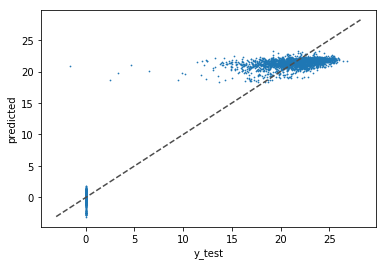

In [166]:
ax = compare.plot.scatter(x='y_test',y='predicted',s=0.5)
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

# 5a' Reproduce Justin's Full reg
*  d$precip_2 <- d$precip ^ 2
            d$precip_3 <- d$precip ^ 3
            d$temperature_2 <- d$temperature ^ 2
            d$temperature_3 <- d$temperature ^ 3
            d$minutes_to_market_2 <- d$minutes_to_market ^ 2
            d$minutes_to_market_3 <- d$minutes_to_market ^ 3
            d$gdp_gecon_2 <- d$gdp_gecon ^ 2
            d$gdp_gecon_3 <- d$gdp_gecon ^ 3
            d$altitude_2 <- d$altitude ^ 2
            d$altitude_3 <- d$altitude ^ 3
            d$slope_2 <- d$slope ^ 2
            d$slope_3 <- d$slope ^ 3
            d$crop_suitability_2 <- d$crop_suitability ^ 2
            d$crop_suitability_3 <- d$crop_suitability ^ 3

In [134]:
dfFull = dfLog

In [135]:
for var in ['precip','temperature','minutes_to_market','gdp_gecon','altitude','slope']:#,'crop_suitability']:
    for i in range(2,4):
        dfFull[var+str(i)] = dfFull[var].pow(i)

In [136]:
dfFull.columns

Index(['calories_per_cell', 'precip', 'temperature', 'gdp_2000',
       'minutes_to_market', 'workability', 'toxicity', 'rooting_conditions',
       'protected_areas', 'oxygen_availability', 'nutrient_retention',
       'nutrient_availability', 'excess_salts', 'gdp_gecon', 'slope',
       'altitude', 'climate_zone', 'has_ag', 'precip2', 'precip3',
       'temperature2', 'temperature3', 'minutes_to_market2',
       'minutes_to_market3', 'gdp_gecon2', 'gdp_gecon3', 'altitude2',
       'altitude3', 'slope2', 'slope3'],
      dtype='object')

In [137]:
linreg(dfFull) # With climate zones

Mean R2 score:  -14.880956652006734


In [139]:
linreg(dfFull) # Without climate zones

Mean R2 score:  -13.99725571333521


# 5b Models: XGBoost

In [24]:
def xgboost_reg(dataframe):
    ##Must make dummies for categorical variable climate_zone
    #dataframe = pd.get_dummies(dataframe, columns=['climate_zone'])
    #Or just drop column if don't want dummies: (put following line under referecning of x)
    #x = x.drop(['climate_zone'], axis=1)

    x = dataframe.drop(['calories_per_cell'], axis=1)
    y = dataframe['calories_per_cell']
    

    ### XGBoost Regressor
    xgbreg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

    ### Cross validation R2 score

    cv_scores = cross_val_score(xgbreg, x, y, cv=10)

    print('Mean R2 score: ', np.mean(cv_scores))

##### Without climate zones

In [25]:
xgboost_reg(dfLog)

Mean R2 score:  -0.7161391062435604


In [140]:
xgboost_reg(dfFull)

Mean R2 score:  -0.6906069325465378


##### With climate zones

In [20]:
xgboost_reg(dfLog)

Mean R2 score:  -0.7161391062435604


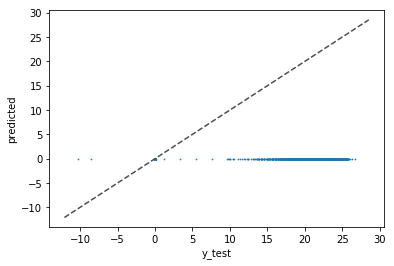

In [167]:
dataframe = dfLog

x = dataframe.drop(['calories_per_cell','climate_zone'], axis=1)
y = dataframe['calories_per_cell']
X_train, X_test, y_train, y_test = train_test_split(x, y)

xgbreg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xg =  xgbreg.fit(X_train, y_train)
y_predicted = xg.predict(X_test)

compare = pd.DataFrame()
compare['y_test'] = y_test
compare['predicted'] = y_predicted 

#Bunch of negative values

ax = compare.plot.scatter(x='y_test',y='predicted',s=0.5)
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

# 5c Tobit (censored regression)

## from https://github.com/jamesdj/tobit/blob/master/tobit.ipynb

from tobit import * --> Learn how to put the next cell tobit.py as a package??

In [35]:
import math
import warnings

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.stats
from scipy.special import log_ndtr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


def split_left_right_censored(x, y, cens):
    counts = cens.value_counts()
    if -1 not in counts and 1 not in counts:
        warnings.warn("No censored observations; use regression methods for uncensored data")
    xs = []
    ys = []

    for value in [-1, 0, 1]:
        if value in counts:
            split = cens == value
            y_split = np.squeeze(y[split].values)
            x_split = x[split].values

        else:
            y_split, x_split = None, None
        xs.append(x_split)
        ys.append(y_split)
    return xs, ys


def tobit_neg_log_likelihood(xs, ys, params):
    x_left, x_mid, x_right = xs
    y_left, y_mid, y_right = ys

    b = params[:-1]
    # s = math.exp(params[-1])
    s = params[-1]

    to_cat = []

    cens = False
    if y_left is not None:
        cens = True
        left = (y_left - np.dot(x_left, b))
        to_cat.append(left)
    if y_right is not None:
        cens = True
        right = (np.dot(x_right, b) - y_right)
        to_cat.append(right)
    if cens:
        concat_stats = np.concatenate(to_cat, axis=0) / s
        log_cum_norm = scipy.stats.norm.logcdf(concat_stats)  # log_ndtr(concat_stats)
        cens_sum = log_cum_norm.sum()
    else:
        cens_sum = 0

    if y_mid is not None:
        mid_stats = (y_mid - np.dot(x_mid, b)) / s
        mid = scipy.stats.norm.logpdf(mid_stats) - math.log(max(np.finfo('float').resolution, s))
        mid_sum = mid.sum()
    else:
        mid_sum = 0

    loglik = cens_sum + mid_sum

    return - loglik


def tobit_neg_log_likelihood_der(xs, ys, params):
    x_left, x_mid, x_right = xs
    y_left, y_mid, y_right = ys

    b = params[:-1]
    # s = math.exp(params[-1]) # in censReg, not using chain rule as below; they optimize in terms of log(s)
    s = params[-1]

    beta_jac = np.zeros(len(b))
    sigma_jac = 0

    if y_left is not None:
        left_stats = (y_left - np.dot(x_left, b)) / s
        l_pdf = scipy.stats.norm.logpdf(left_stats)
        l_cdf = log_ndtr(left_stats)
        left_frac = np.exp(l_pdf - l_cdf)
        beta_left = np.dot(left_frac, x_left / s)
        beta_jac -= beta_left

        left_sigma = np.dot(left_frac, left_stats)
        sigma_jac -= left_sigma

    if y_right is not None:
        right_stats = (np.dot(x_right, b) - y_right) / s
        r_pdf = scipy.stats.norm.logpdf(right_stats)
        r_cdf = log_ndtr(right_stats)
        right_frac = np.exp(r_pdf - r_cdf)
        beta_right = np.dot(right_frac, x_right / s)
        beta_jac += beta_right

        right_sigma = np.dot(right_frac, right_stats)
        sigma_jac -= right_sigma

    if y_mid is not None:
        mid_stats = (y_mid - np.dot(x_mid, b)) / s
        beta_mid = np.dot(mid_stats, x_mid / s)
        beta_jac += beta_mid

        mid_sigma = (np.square(mid_stats) - 1).sum()
        sigma_jac += mid_sigma

    combo_jac = np.append(beta_jac, sigma_jac / s)  # by chain rule, since the expression above is dloglik/dlogsigma

    return -combo_jac


class TobitModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.ols_coef_ = None
        self.ols_intercept = None
        self.coef_ = None
        self.intercept_ = None
        self.sigma_ = None

    def fit(self, x, y, cens, verbose=False):
        """
        Fit a maximum-likelihood Tobit regression
        :param x: Pandas DataFrame (n_samples, n_features): Data
        :param y: Pandas Series (n_samples,): Target
        :param cens: Pandas Series (n_samples,): -1 indicates left-censored samples, 0 for uncensored, 1 for right-censored
        :param verbose: boolean, show info from minimization
        :return:
        """
        x_copy = x.copy()
        if self.fit_intercept:
            x_copy.insert(0, 'intercept', 1.0)
        else:
            x_copy.scale(with_mean=True, with_std=False, copy=False)
        init_reg = LinearRegression(fit_intercept=False).fit(x_copy, y)
        b0 = init_reg.coef_
        y_pred = init_reg.predict(x_copy)
        resid = y - y_pred
        resid_var = np.var(resid)
        s0 = np.sqrt(resid_var)
        params0 = np.append(b0, s0)
        xs, ys = split_left_right_censored(x_copy, y, cens)

        result = minimize(lambda params: tobit_neg_log_likelihood(xs, ys, params), params0, method='BFGS',
                          jac=lambda params: tobit_neg_log_likelihood_der(xs, ys, params), options={'disp': verbose})
        if verbose:
            print(result)
        self.ols_coef_ = b0[1:]
        self.ols_intercept = b0[0]
        if self.fit_intercept:
            self.intercept_ = result.x[1]
            self.coef_ = result.x[1:-1]
        else:
            self.coef_ = result.x[:-1]
            self.intercept_ = 0
        self.sigma_ = result.x[-1]
        return self

    def predict(self, x):
        return self.intercept_ + np.dot(x, self.coef_)

    def score(self, x, y, scoring_function=mean_absolute_error):
        y_pred = np.dot(x, self.coef_)
        return scoring_function(y, y_pred)

In [69]:
dataframe = dfLog

x = dataframe.drop(['calories_per_cell','climate_zone'], axis=1)
y = dataframe['calories_per_cell']
X_train, X_test, y_train, y_test = train_test_split(x, y)

##Unsure about this 'cens' part
cens = pd.Series(np.zeros((len(y_train),)))
cens[left] = -1
cens[right] = 1
##See below

tob = TobitModel().fit(X_train, y_train,cens)
y_predicted = tob.predict(X_test)

TypeError: fit() missing 1 required positional argument: 'cens'

In [32]:
compare = pd.DataFrame()
compare['y_test'] = y_test
compare['predicted'] = y_predicted 

#Bunch of negative values

In [60]:
## WTF? : below

In [72]:
(len(y))

21680

In [77]:
cens = pd.Series(np.zeros((20,)))

In [80]:
cens[left] = -1
cens[right] = 1

In [81]:
cens

0    -1.0
1    -1.0
2     0.0
3     1.0
4     0.0
5     1.0
6    -1.0
7     1.0
8    -1.0
9     0.0
10    0.0
11    0.0
12    0.0
13   -1.0
14    0.0
15    0.0
16    0.0
17    1.0
18    1.0
19    1.0
dtype: float64

## from 